In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import torch
import sklearn.cluster as sl

In [2]:
def sqrtinvdiag(M):
    """Inverts and square-roots a positive diagonal matrix.
    Args:
        M (csc matrix): matrix to invert
    Returns:
        scipy sparse matrix of inverted square-root of diagonal
    """

    d = M.diagonal()
    dd = [1 / max(np.sqrt(x), 1 / 999999999) for x in d]

    return sp.dia_matrix((dd, [0]), shape=(len(d), len(d))).tocsc()

In [3]:
adj = sp.load_npz('./HeadToHeadadj.npz')
adj

<602x602 sparse matrix of type '<class 'numpy.float32'>'
	with 5010 stored elements in Compressed Sparse Row format>

[ 2 46  8  7  0 48 14  6  4 47 51 66  9 10 26 12 21 68 52 53  5 78 74 63
 50 81  3 65 24 61 76 13 29 77 25 58 22 84 64 41 34 33 54 91 86 11 72 49
 83 44 67 97 55 39 16 71 36 27 19 17 82 20 18 45 60 75 15  1 89 69 57 79
 28 62 98 31 43 95 38 85 73 32 23 94 88 37 96 92 90 40 56 70 87 35 59 42
 30 80 93]
[0.02649832 0.00407946 0.11665535 0.0087676  0.02099872 0.01004565
 0.02221191 0.02873552 0.03574371 0.01589835 0.01477158 0.00585258
 0.01237106 0.00797021 0.02270877 0.00419533 0.00528622 0.00500023
 0.00459039 0.00518012 0.00468564 0.01124406 0.00693095 0.00228834
 0.00861645 0.00722599 0.01386786 0.00521314 0.00361741 0.00743294
 0.00103188 0.00353038 0.00230777 0.00614703 0.00615406 0.00128043
 0.00522566 0.00180233 0.00293624 0.00532734 0.00161326 0.00619721
 0.00107849 0.00299418 0.00564593 0.00455487 0.05138212 0.01994699
 0.02323198 0.00582349 0.00931531 0.01815391 0.0102511  0.01006413
 0.00601572 0.00551409 0.00157982 0.0038442  0.0071944  0.00126439
 0.00451982 0.00844431 0.00

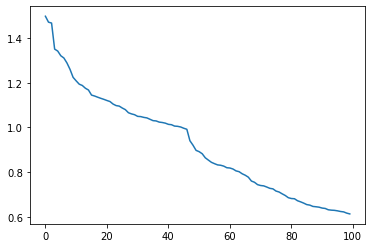

In [4]:
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 100)
eigens = s[list(np.arange(99,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 48

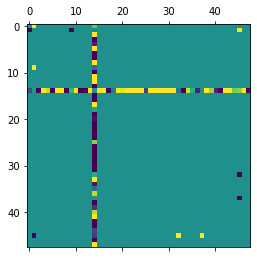

39

In [5]:
num_clusters = 48
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)